In [1]:
using LaplaceRedux.Data
using Flux

using CSV
using DataFrames

df = CSV.read("data1.csv", DataFrame)
x = Matrix(df[:, 1:2])
x = [x[i, :] for i in 1:size(x, 1)]
y = df[:, 3]

# Prepare data for training
X = hcat(x...)
y_train = Flux.onehotbatch(y, unique(y[:, 1]))
y_train = Flux.unstack(y_train', 1)
println(x)

[[2.2603356761687, 5.338331365373949], [4.251785399572086, 5.0985906105854175], [2.1183408444254486, 3.8115749394749856], [3.011478933357825, 2.3588573998781346], 

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.1.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA C:\Users\Lenovo\.julia\packages\CUDA\s0e3j\src\initialization.jl:70


[2.9008069881768708, 4.861709057756418], [5.108587493388329, 5.132593346145286], [2.5563410728094813, 1.671106188705799], [4.4466000488449176, 3.807305405732485], [2.658365052421698, 1.7919228292184861], [2.6212524206150865, 4.991352791662504], [2.480883127937373, 4.13023327675971], [1.1886708076011399, 5.2069649924550605], [2.4868747838926986, 4.304306553879949], [3.4804623630130354, 5.05921976615622], [3.8917717649474266, 3.2123663409905596], [3.5684059253824234, 3.941396510117216], [3.615930336236345, 3.6186306701447175], [1.7724546684603988, 1.4365546962925375], [4.090119108858124, 3.286234381327473], [3.2044529970282425, 1.9775349696610607], [4.718783056577633, 2.3002091670921905], [1.3006978337530626, 2.332349026539805], [1.2066264851055672, 3.362700252357945], [3.9631590328485578, 3.408969593294743], [3.3917378380817373, 1.217870800150647], [-2.6758438872443726, -2.8583116068357386], [-5.2804870729817655, -3.3998918210864044], [-3.6252509309043734, -3.6107887627062825], [-6.0945

In [2]:
data = zip(x,y_train)
n_hidden = 3
D = size(X,1)
println(size(X))
println(X)
out_dim = length(unique(y))
nn = Chain(
    Dense(D, n_hidden, σ),
    Dense(n_hidden, out_dim)
)  
loss(x, y) = Flux.Losses.logitcrossentropy(nn(x), y)

(2, 100)
[2.2603356761687 4.251785399572086 2.1183408444254486 3.011478933357825 2.9008069881768708 5.108587493388329 2.5563410728094813 4.4466000488449176 2.658365052421698 2.6212524206150865 2.480883127937373 1.1886708076011399 2.4868747838926986 3.4804623630130354 3.8917717649474266 3.5684059253824234 3.615930336236345 1.7724546684603988 4.090119108858124 3.2044529970282425 4.718783056577633 1.3006978337530626 1.2066264851055672 3.9631590328485578 3.3917378380817373 -2.6758438872443726 -5.2804870729817655 -3.6252509309043734 -6.0945667782350235 -3.999117173489958 -4.964055617715966 -4.453916611155287 -4.646517037869483 -5.523379250417538 -3.2512778453037456 -2.7528154147159967 -3.061505077404164 -6.58255105771363 -5.149020377750359 -5.544645743553041 -3.2688621252538974 -3.3460567615046584 -6.8133915653622 -3.6218049570576274 -5.800375953382498 -2.7580435579568343 -3.332001819159378 -4.294989565529624 -6.160413053273565 -6.621804640580541 3.5030631764082907 3.018522245190033 3.09486

loss (generic function with 1 method)

In [3]:
using Flux.Optimise: update!, Adam
using Statistics
opt = Adam()
epochs = 100
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))
show_every = epochs/10

for epoch = 1:epochs
    for d in data
        gs = gradient(Flux.params(nn)) do
            l = loss(d...)
        end
        update!(opt, Flux.params(nn), gs)
    end
    if epoch % show_every == 0
        println("Epoch " * string(epoch))
        @show avg_loss(data)
    end
end

Epoch 10

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 3, σ)    # 9 parameters
│   summary(x) = "2-element Vector{Float64}"
└ @ Flux C:\Users\Lenovo\.julia\packages\Flux\FWgS0\src\layers\stateless.jl:50



avg_loss(data) = 0.7633906f0
Epoch 20
avg_loss(data) = 0.5285912f0
Epoch 30
avg_loss(data) = 0.38079032f0
Epoch 40
avg_loss(data) = 0.2809952f0
Epoch 50
avg_loss(data) = 0.21000713f0
Epoch 60
avg_loss(data) = 0.1580676f0
Epoch 70
avg_loss(data) = 0.11945122f0
Epoch 80
avg_loss(data) = 0.09044135f0
Epoch 90
avg_loss(data) = 0.068521336f0
Epoch 100
avg_loss(data) = 0.05191145f0


In [4]:
using LaplaceRedux
la = Laplace(nn; likelihood=:classification)
fit!(la, data)
optimize_prior!(la; verbose=true, n_steps=1000)

loss(exp.(logP₀), exp.(logσ)) = 11.299564864637205
Log likelihood: -5.191145077347755
Log det ratio: 7.499458070304485
Scatter: 4.717381504274416


[ Info: Iteration 100: P₀=0.03438779314380501, σ=1.0
[ Info: Iteration 200: P₀=0.026203027657670405, σ=1.0


loss(exp.(logP₀), exp.(logσ)) = 11.193381693889428
Log likelihood: -5.191145077347755
Log det ratio: 8.409893100785624
Scatter: 3.594580132297723
loss(exp.(logP₀), exp.(logσ)) = 11.192083530156424
Log likelihood: -5.191145077347755
Log det ratio: 8.525127434678012
Scatter: 3.476749470939326

[ Info: Iteration 300: P₀=0.025344090044691923, σ=1.0



loss(exp.(logP₀), exp.(logσ)) = 11.192080016914279
Log likelihood: -5.191145077347755
Log det ratio: 8.531401283276196
Scatter: 3.4704685958568504
loss(exp.(logP₀), exp.(logσ)) = 11.19208001611695
Log likelihood: -5.191145077347755
Log det ratio: 8.531497467392342
Scatter: 3.470372410146049

[ Info: Iteration 400: P₀=0.025298305019057988, σ=1.0
[ Info: Iteration 500: P₀=0.025297603864334037, σ=1.0



loss(exp.(logP₀), exp.(logσ)) = 11.192080016116918
Log likelihood: -5.191145077347755
Log det ratio: 8.531497273727467
Scatter: 3.470372603810858
loss(exp.(logP₀), exp.(logσ)) = 11.19208001611692
Log likelihood: -5.191145077347755

[ Info: Iteration 600: P₀=0.02529760527607175, σ=1.0
[ Info: Iteration 700: P₀=0.025297605271040236, σ=1.0



Log det ratio: 8.531497274417703
Scatter: 3.4703726031206257
loss(exp.(logP₀), exp.(logσ)) = 11.192080016116936
Log likelihood: -5.191145077347755
Log det ratio: 8.531497274409844
Scatter: 3.4703726031285176

[ Info: Iteration 800: P₀=0.025297605271097767, σ=1.0



loss(exp.(logP₀), exp.(logσ)) = 11.19208001611693
Log likelihood: -5.191145077347755
Log det ratio: 8.531497274409887
Scatter: 3.4703726031284647

[ Info: Iteration 900: P₀=0.025297605271097385, σ=1.0



loss(exp.(logP₀), exp.(logσ)) = 11.19208001611693
Log likelihood: -5.191145077347755
Log det ratio: 8.531497274409887
Scatter: 3.4703726031284647


[ Info: Iteration 1000: P₀=0.025297605271097385, σ=1.0


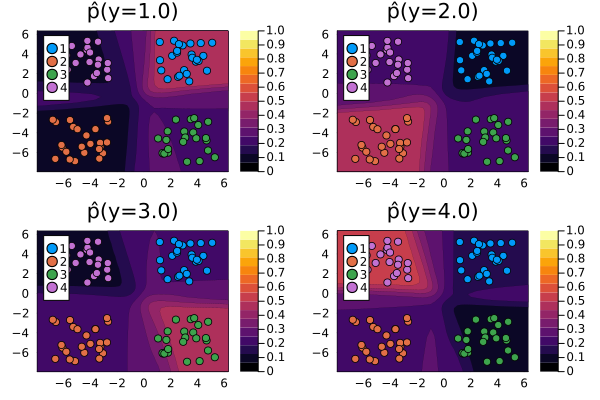

In [5]:
using Plots
_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1))
    push!(plt_list, plt)
end
plot(plt_list...)

In [6]:
predictions_probit = predict(la, X)
println(reduce(hcat, predictions_probit))

[0.4967788429258321 0.10480098008338559 0.2449349427947153 0.15348523419606697 0.49748264187044217 0.10458486424987244 0.2448583724816797 0.1530741213980057 0.4960354326476712 0.10500486499189388 0.24506245466771667 0.1538972476927183 0.4970594612568375 0.10472140096138532 0.24503815297552517 0.15318098480625192 0.49732239252094074 0.10463617061512005 0.24486441038712053 0.15317702647681863 0.497490131282176 0.1045823649735369 0.24485856337884487 0.15306894036544202 0.4953259019960007 0.10525200695294833 0.24601916848344618 0.1534029225676048 0.49747942491938013 0.10458598697383481 0.24486218273878202 0.1530724053680029 0.4959217416629134 0.105073535751729 0.24569069131782414 0.15331403126753346 0.4971776851992729 0.104680803511203 0.24487801510418536 0.15326349618533885 0.4969495753557949 0.10474729775720223 0.2449049095431976 0.1533982173438052 0.47896512324966073 0.11047144344732551 0.2489342726276473 0.16162916067536642 0.4969793032461204 0.10473883988293163 0.24490133847394197 0.1

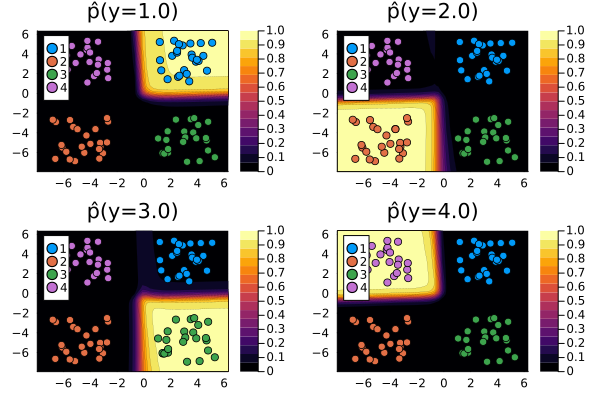

In [7]:
_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1), link_approx=:plugin)
    push!(plt_list, plt)
end
plot(plt_list...)

In [8]:
predictions_plugin = predict(la, X, link_approx=:plugin)
println(reduce(hcat, predictions_plugin))

Float32[0.9389276 0.00067359384 0.05602132 0.004377488 0.9392278 0.00066461344 0.055800933 0.0043066517 0.93864095 0.0006814215 0.056236327 0.0044412906 0.93884736 0.00067117286 0.056149367 0.0043320563 0.9391413 0.0006670253 0.055865433 0.004326205 0.9392325 0.0006644875 0.055797346 0.004305606 0.9373496 0.00069353555 0.057584945 0.0043719094 0.93922216 0.00066467567 0.055806637 0.0043064887 0.93783176 0.00068632374 0.057122543 0.004359381 0.9390759 0.0006689514 0.055913605 0.0043415073 0.93897235 0.00067177706 0.05599141 0.0043644034 0.93604606 0.0007774468 0.058018964 0.0051575727 0.93898714 0.00067140465 0.05598012 0.0043613683 0.93920636 0.0006651987 0.055817038 0.004311448 0.9391865 0.0006653059 0.05583903 0.004309174 0.9391992 0.0006653202 0.055823386 0.004312067 0.93919414 0.00066537346 0.055828553 0.0043118936 0.9344696 0.00075833034 0.060018595 0.0047534998 0.93919766 0.0006650765 0.05582948 0.0043077995 0.9384431 0.00067553075 0.056564808 0.0043165023 0.93889815 0.0006685728